In [1]:
# imports
import sys
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle, islice
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import ndcg_score
from collections import defaultdict
from scipy import stats
from surprise import AlgoBase
from surprise import BaselineOnly
from surprise import KNNBasic
from surprise import KNNWithMeans
from surprise import NMF
from surprise import Dataset
from surprise import Reader
from surprise import accuracy
from surprise import CoClustering
from surprise.model_selection import train_test_split, KFold

In [2]:
# constants and initialization
dataset = 'lfm' # ml, anime
item_threshold = 1 # 1 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'item'
top_fraction = 0.2
folds = 5
user_events_cats_file = dataset + '/user_events_cats.txt'
low_user_file = dataset + '/low_main_users.txt'
medium_user_file = dataset + '/medium_main_users.txt'
high_user_file = dataset + '/high_main_users.txt'

save_metrics = False

cats_file = dataset + '/categories.txt'

In [3]:
cols_cats = ['user', 'item', 'preference', 'cats']
df_events_cats = pd.read_csv(user_events_cats_file, sep=',').dropna()
df_events_cats.columns = cols_cats
df_events_cats['cats'] = df_events_cats['cats'].astype(str)
df_events_cats

,user,item,preference,cats
0,1021445,57,123.148472,3|16|15|18
1,1021445,113,1.000000,2|16|18|3
2,1021445,137,101.336245,2|3|16|0
3,1021445,142,9.724891,0|3|2
4,1021445,179,5.362445,16|1|3|18|15|0
...,...,...,...,...
1417786,50071075,543672,61.775665,12
1417787,50071075,28392,23.790875,13|12|3
1417788,50071075,201181,8.596958,12|15
1417789,50071075,2902578,4.798479,5|3


In [4]:
df_events_cats = df_events_cats[df_events_cats['preference'] >= item_threshold]
print('No. filtered user events: ' + str(len(df_events_cats)))
print('No. filtered items: ' + str(len(df_events_cats[predict_col].unique())))
print('No. filtered users: ' + str(len(df_events_cats['user'].unique())))

No. filtered user events: 1417791
No. filtered items: 131188
No. filtered users: 3000


In [5]:
# get user distribution
user_dist = df_events_cats['user'].value_counts()
num_users = len(user_dist)
print('Mean items per user: ' + str(user_dist.mean()))
print('Min items per user: ' + str(user_dist.min()))
print('Max items per user: ' + str(user_dist.max()))

Mean items per user: 472.597
Min items per user: 13
Max items per user: 2901


In [6]:
# get item distribution
item_dist = df_events_cats[predict_col].value_counts()
num_items = len(item_dist)
print('No. items: ' + str(num_items))

No. items: 131188


In [7]:
item_dist

135       1389
1602      1359
46        1325
320       1297
27        1290
          ... 
270452       1
270477       1
270313       1
270496       1
328694       1
Name: item, Length: 131188, dtype: int64

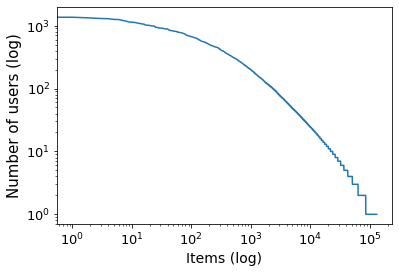

In [8]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xlabel('Items (log)', fontsize='14')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of users (log)', fontsize='15')
plt.xscale('log')
plt.yscale('log')
# plt.savefig(dataset + '/graphs/item_dist.png', dpi=300, bbox_inches='tight')

In [9]:
# get top items
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
print('No. top items: ' + str(len(top_item_dist)))

No. top items: 26237


In [10]:
# read users
low_users = pd.read_csv(low_user_file, sep=',').set_index('user')
medium_users = pd.read_csv(medium_user_file, sep=',').set_index('user')
high_users = pd.read_csv(high_user_file, sep=',').set_index('user')
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 3000


Text(0.5, 1.0, 'LFM')

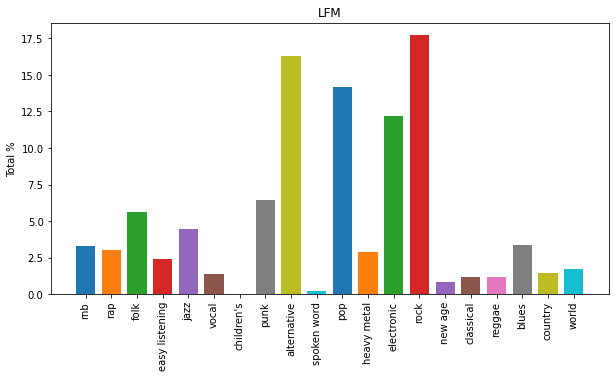

In [11]:
df_cats = pd.read_csv(cats_file, sep=',')
#df_cats.set_index('index', inplace=True)
df_cats.columns = ['name', 'cats']

df_test = df_events_cats.copy()
df_test.drop(['item', 'preference'], axis=1, inplace=True)
df_test["cats"] = df_test["cats"].str.split("|")
df_test = df_test.explode("cats").reset_index(drop=True)
df_test = df_test.groupby('cats').count().reset_index()#.set_index('cats')

df_test['cats'] = df_test['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
df_test = df_test.merge(df_cats, on='cats')
#df_test['name'] = df_cats['cat']
df_test.set_index('cats', inplace=True)
#print(df_test)
df_test.columns = ['count', 'category']
df_test['count'] /= (df_test['count'].sum() / 100)
#df_test.plot.bar(x='category', y='count')
df_test_T = df_test.set_index('category').T
#df_test_T.plot.bar(width=1.5, align='center')
height = df_test['count'].to_list()
x = [x for x in range(len(df_test_T.columns))]

plt.figure(figsize=(10,5))
for i in range(len(x)):
    plt.bar(x=x[i], height=height[i], width=.75, label=df_test_T.columns[i])
#plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., framealpha=1, fontsize='15')
plt.ylabel("Total %")
plt.xticks([x for x in range(len(df_test_T.columns))], labels=df_test_T.columns, rotation=90)
plt.title({'anime':'MAL', 'book':'BookCrossing', 'movie':'ML', 'music':'LFM', 'yahoo':'Yahoo! Movies'}[dataset])
# plt.savefig(dataset + '/graphs/genres.png', dpi=300, bbox_inches='tight')

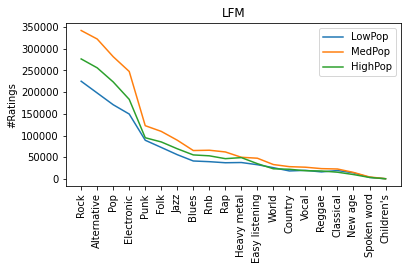

1266832
1961456
1540289


In [12]:
# Get dataset
df_item_pop = df_events_cats.copy()
# Remove unnecessary columns
df_item_pop.drop(['item', 'preference'], axis=1, inplace=True)
# Split cat column and count their occurrence
df_item_pop["cats"] = df_item_pop["cats"].str.split("|")
df_item_pop = df_item_pop.explode("cats").reset_index(drop=True)

df_item_pop_cats = df_item_pop.groupby('cats').count().reset_index()
df_item_pop_cats.columns = ['cats', 'Total']
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_item_pop_group = df_item_pop.loc[df_item_pop['user'].isin([low_users, medium_users, high_users][i].index)]
    df_item_pop_cats[groups[i]] = df_item_pop_group.groupby('cats').count().reset_index()['user']

# Make sure column types are the same (needed for merge)
df_item_pop_cats['cats'] = df_item_pop_cats['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
# Merge to get category names (str)
df_item_pop_cats = df_item_pop_cats.merge(df_cats, on='cats')
# Set cats column as index
df_item_pop_cats.set_index('cats', inplace=True)
df_item_pop_cats = df_item_pop_cats.sort_values('Total',ignore_index=True, ascending=False)

if dataset == 'anime':
    df_item_pop_cats = df_item_pop_cats.drop(range(20, 36)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(21, 28)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(7, 8)).reset_index(drop=True)
df_item_pop_cats.plot.line(y=groups, x='name', figsize=(6, 3), legend=True)
#df_item_pop_cats.plot.line(y='Total', x='name', figsize=(6, 3), legend=True)
labels = [label.capitalize() for label in list(df_item_pop_cats['name'])]

plt.title({'anime':'MAL', 'book':'BookCrossing', 'movie':'ML', 'music':'LFM', 'yahoo':'Yahoo! Movies'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("#Ratings")
plt.xlabel("")
plt.savefig(dataset+'/'+dataset+'_item_pop.pdf', dpi=300, bbox_inches='tight')
plt.show()

for i in range(len(groups)):
    print(df_item_pop_cats[groups[i]].sum())

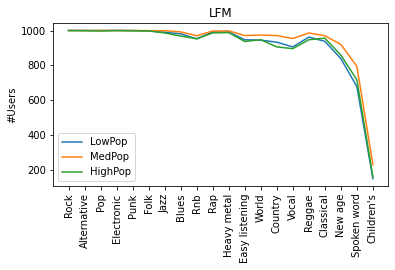

In [13]:
# Get dataset
df_item_pop = df_events_cats.copy()
# Remove unnecessary columns
df_item_pop.drop(['item', 'preference'], axis=1, inplace=True)
# Split cat column and count their occurrence
df_item_pop["cats"] = df_item_pop["cats"].str.split("|")
df_item_pop = df_item_pop.explode("cats").reset_index(drop=True)

df_item_pop_cats = df_item_pop.groupby('cats').count().reset_index()
df_item_pop_cats.columns = ['cats', 'Total']
groups = ['LowPop', 'MedPop', 'HighPop']

sum_col = 'Sum'
df_item_pop_cats[sum_col] = 0
for i in range(len(groups)):
    df_item_pop_group = df_item_pop.loc[df_item_pop['user'].isin([low_users, medium_users, high_users][i].index)]
    df_item_pop_group = df_item_pop_group.drop_duplicates(subset=['user', 'cats'])
    #df_item_pop_cats[sum_col] += df_item_pop_group.groupby('cats').count().reset_index()['user']
    df_item_pop_cats[groups[i]] = df_item_pop_group.groupby('cats').count().reset_index()['user']

# Make sure column types are the same (needed for merge)
df_item_pop_cats['cats'] = df_item_pop_cats['cats'].astype(int)
df_cats['cats'] = df_cats['cats'].astype(int)
# Merge to get category names (str)
df_item_pop_cats = df_item_pop_cats.merge(df_cats, on='cats')
# Set cats column as index
df_item_pop_cats.set_index('cats', inplace=True)

df_item_pop_cats = df_item_pop_cats.sort_values('Total',ignore_index=True, ascending=False)
#df_item_pop_cats = df_item_pop_cats.sort_values(sum_col,ignore_index=True, ascending=False)

if dataset == 'anime':
    df_item_pop_cats = df_item_pop_cats.drop(range(20, 36)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(21, 28)).reset_index(drop=True)
    df_item_pop_cats = df_item_pop_cats.drop(range(7, 8)).reset_index(drop=True)
df_item_pop_cats.plot.line(y=groups, x='name', figsize=(6, 3), legend=True)
#df_item_pop_cats.plot.line(y=sum_col, x='name', figsize=(6, 3), legend=False)
labels = [label.capitalize() for label in list(df_item_pop_cats['name'])]

plt.title({'anime':'MAL', 'book':'BookCrossing', 'movie':'ML', 'music':'LFM', 'yahoo':'Yahoo! Movies'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("#Users")
plt.xlabel("")
plt.savefig(dataset+'/'+dataset+'_user_genres.pdf', dpi=300, bbox_inches='tight')
plt.show()

In [14]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes
pop_fraq = [] # relative number of top items per user
pop_item_fraq = [] # average popularity of items in user profiles
low_profile_size = 0
low_gap = 0
medium_profile_size = 0
medium_gap = 0
high_profile_size = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0
df_gap_p = pd.DataFrame(columns=['user', 'gap_p'])
df_gap_p_items = pd.DataFrame(columns=['user', 'item', 'gap_p'])
for u, df in df_events_cats.groupby('user'):
    no_user_items = len(set(df[predict_col])) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile
    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq.append(no_user_pop_items / no_user_items)
    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    user_pop_item_fraq = sum(item_dist[df[predict_col]] / no_users) / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    df_gap_p = pd.concat([df_gap_p, pd.DataFrame.from_dict({'user': [u], 'gap_p': [user_pop_item_fraq]})], ignore_index=True)

    item_list = list(df[predict_col])
    df_gap_p_items = pd.concat([df_gap_p_items, pd.DataFrame.from_dict({'user': [u for _ in item_list], 'item': item_list, 'gap_p': [user_pop_item_fraq for _ in item_list]})], ignore_index=True)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_count += 1
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        med_count += 1
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_count += 1
low_profile_size /= len(low_users)
medium_profile_size /= len(medium_users)
high_profile_size /= len(high_users)
low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 1000
Med count (for check): 1000
High count (for check): 1000


In [15]:
print('Average LowMS profile size: ' + str(low_profile_size))
print('Average MedMS profile size: ' + str(medium_profile_size))
print('Average HighMS profile size: ' + str(high_profile_size))

Average LowMS profile size: 393.21
Average MedMS profile size: 580.416
Average HighMS profile size: 444.165


## Recommendations using Surprise package


In [16]:
#df_events = scaled_df_events
print('Min rating: ' + str(df_events_cats['preference'].min()))
print('Max rating: ' + str(df_events_cats['preference'].max()))

Min rating: 1.0
Max rating: 1000.0


In [17]:
reader = Reader(rating_scale=(df_events_cats['preference'].min(), df_events_cats['preference'].max()))

In [18]:
data = Dataset.load_from_df(df_events_cats[df_events_cats.columns[:-1]], reader)
kf = KFold(n_splits=folds, random_state=my_seed)

In [19]:
def get_top_n(predictions, n=10):
    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))
    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]
    return top_n

In [20]:
def get_top_n_random(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for i in range(0, 10):
                top_n[uid].append((rd.choice(item_dist.index), i))
    return top_n

In [21]:
def get_top_n_mp(testset, n=10):
    top_n = defaultdict(list)
    for uid, iid, true_r in testset:
        if len(top_n[uid]) == 0:
            for iid, count in item_dist[:n].items():
                top_n[uid].append((iid, count))
    return top_n

In [22]:
def get_mae_of_groups(predictions):
    low_predictions = []
    med_predictions = []
    high_predictions = []
    dict_maes = {'user': [], 'item': [], 'mae': []}
    for uid, iid, true_r, est, details in predictions:
        prediction = [(uid, iid, true_r, est, details)]
        dict_maes['user'].append(uid)
        dict_maes['item'].append(iid)
        dict_maes['mae'].append(accuracy.mae(prediction, verbose=False))

        if uid in low_users.index:
            low_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in medium_users.index:
            med_predictions.append(accuracy.mae(prediction, verbose=False))
        elif uid in high_users.index:
            high_predictions.append(accuracy.mae(prediction, verbose=False))

    return pd.DataFrame.from_dict(dict_maes), [low_predictions, med_predictions, high_predictions]

In [23]:
# create item dataframe with normalized item counts
df_item_dist = pd.DataFrame(item_dist)
df_item_dist.columns = ['count']
df_item_dist['count'] /= no_users

In [24]:
sim_users = {'name': 'cosine', 'user_based': True}  # compute cosine similarities between users
algos = [BaselineOnly(),
         KNNBasic(sim_options=sim_users),
         KNNWithMeans(sim_options=sim_users),
         NMF(n_factors=30, random_state=my_seed),
         CoClustering(n_cltr_u=3, n_cltr_i=3, random_state=my_seed)]
algo_names = ['UserItemAvg',
              'UserKNN',
              'UserKNNAvg',
              'NMF',
              'Co-Custering']

In [25]:
q = [{} for _ in range(folds)]
maes = {}
maes_user = {}
low_rec_gap_list = [] # one entry per algorithm
medium_rec_gap_list = []
high_rec_gap_list = []
gaps_q = {}
for i in range(0, len(algo_names)):
    print(algo_names[i])

    df_item_dist[algo_names[i]] = 0
    low_rec_gaps = [0 for _ in range(folds)]
    medium_rec_gaps = [0 for _ in range(folds)]
    high_rec_gaps = [0 for _ in range(folds)]

    fold = 0
    mae_list = []
    predictions_maes = [0 for _ in range(3)]
    for trainset, testset in kf.split(data):
        # get accuracy for personalized approaches
        algos[i].fit(trainset)
        predictions = algos[i].test(testset, verbose=False)
        mae_list.append(accuracy.mae(predictions, verbose=False))
        df_mae, predictions_mae = get_mae_of_groups(predictions)
        if algo_names[i] not in maes:
            maes[algo_names[i]] = df_mae
            maes[algo_names[i]]['mae'] /= folds
        else:
            maes[algo_names[i]]['mae'] += df_mae['mae'] / folds

        predictions_maes = [predictions_maes[i] + np.mean(predictions_mae[i])/folds for i in range(3)]
        print(stats.ttest_ind(predictions_mae[0], predictions_mae[1]))
        print(stats.ttest_ind(predictions_mae[0], predictions_mae[2]))

        top_n = get_top_n(predictions, n=10)
        q[fold][algo_names[i]] = top_n.items()

        low_count = 0
        med_count = 0
        high_count = 0
        dict_gap_q = {'user':[], 'gap_q':[]}
        for uid, user_ratings in top_n.items():
            iid_list = []
            for (iid, _) in user_ratings:
                df_item_dist.loc[iid, algo_names[i]] += 1
                iid_list.append(iid)
            gap = sum(item_dist[iid_list] / no_users) / len(iid_list)
            dict_gap_q['user'].append(uid)
            dict_gap_q['gap_q'].append(gap / folds)
            if uid in low_users.index:
                low_rec_gaps[fold] += gap
                low_count += 1
            elif uid in medium_users.index:
                medium_rec_gaps[fold] += gap
                med_count += 1
            elif uid in high_users.index:
                high_rec_gaps[fold] += gap
                high_count += 1

        if algo_names[i] not in gaps_q:
            gaps_q[algo_names[i]] = pd.DataFrame.from_dict(dict_gap_q)
        else:
            gaps_q[algo_names[i]]['gap_q'] += pd.DataFrame.from_dict(dict_gap_q)['gap_q']
        low_rec_gaps[fold] /= low_count
        medium_rec_gaps[fold] /= med_count
        high_rec_gaps[fold] /= high_count
        # check, if all users are used
        print(low_count, med_count, high_count)
        fold += 1

    low_rec_gap_list.append(np.mean(low_rec_gaps))
    medium_rec_gap_list.append(np.mean(medium_rec_gaps))
    high_rec_gap_list.append(np.mean(high_rec_gaps))

    maes_user[algo_names[i]] = maes[algo_names[i]].drop(['item'], axis=1)

    print(np.mean(mae_list))
    print('LowMS: ' + str(predictions_maes[0]))
    print('MedMS: ' + str(predictions_maes[1]))
    print('HighMS: ' + str(predictions_maes[2]))

    i += 1 # next algorithm

UserItemAvg
Estimating biases using als...
Ttest_indResult(statistic=26.78617659365397, pvalue=9.073286956307234e-158)
Ttest_indResult(statistic=7.823789097840463, pvalue=5.155341298124944e-15)
1000 1000 1000
Estimating biases using als...
Ttest_indResult(statistic=25.144468657297303, pvalue=2.7149791404166108e-139)
Ttest_indResult(statistic=6.6378321395920326, pvalue=3.192947443879208e-11)
1000 1000 999
Estimating biases using als...
Ttest_indResult(statistic=25.212334286663125, pvalue=4.929838401571281e-140)
Ttest_indResult(statistic=6.660276095589185, pvalue=2.7415561041831755e-11)
1000 1000 1000
Estimating biases using als...
Ttest_indResult(statistic=26.176072652653477, pvalue=9.09614091905237e-151)
Ttest_indResult(statistic=6.715883526547393, pvalue=1.875231224854115e-11)
1000 1000 1000
Estimating biases using als...
Ttest_indResult(statistic=24.962301203917413, pvalue=2.586607863011874e-137)
Ttest_indResult(statistic=5.509998898998822, pvalue=3.5936147306514286e-08)
1000 1000 10

C:\Users\prism\AppData\Local\Temp\ipykernel_21172\3570483800.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algos[i].fit(trainset)


Ttest_indResult(statistic=31.952931519282867, pvalue=1.873234411471507e-223)
Ttest_indResult(statistic=14.88721994480163, pvalue=4.296304923614652e-50)
1000 1000 1000


C:\Users\prism\AppData\Local\Temp\ipykernel_21172\3570483800.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algos[i].fit(trainset)


Ttest_indResult(statistic=29.094429605915153, pvalue=1.0587369656586664e-185)
Ttest_indResult(statistic=12.719902772536978, pvalue=4.7690474762264835e-37)
1000 1000 999


C:\Users\prism\AppData\Local\Temp\ipykernel_21172\3570483800.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algos[i].fit(trainset)


Ttest_indResult(statistic=29.544416600272314, pvalue=2.0577685779517265e-191)
Ttest_indResult(statistic=11.87234904235796, pvalue=1.6981635114150425e-32)
1000 1000 1000


C:\Users\prism\AppData\Local\Temp\ipykernel_21172\3570483800.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algos[i].fit(trainset)


Ttest_indResult(statistic=30.967790536479537, pvalue=4.759743790671466e-210)
Ttest_indResult(statistic=13.142699812518702, pvalue=1.960436732665142e-39)
1000 1000 1000


C:\Users\prism\AppData\Local\Temp\ipykernel_21172\3570483800.py:21: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  algos[i].fit(trainset)


Ttest_indResult(statistic=29.05931144037006, pvalue=2.931348264395327e-185)
Ttest_indResult(statistic=11.308138606461307, pvalue=1.2259657414167872e-29)
1000 1000 1000
46.03545563186644
LowMS: 52.595205424654765
MedMS: 40.83101806004999
HighMS: 47.02960099386921


In [26]:
d_predictions = [{} for _ in range(folds)]
for fold in range(folds):
    for i in range(len(algo_names)):
        df_a = pd.DataFrame(q[fold][algo_names[i]], columns=['user', 'item_ratings'])
        df_a = df_a.explode('item_ratings')
        df_a[['item', 'rank']] = pd.DataFrame(df_a['item_ratings'].tolist(), index=df_a.index)
        df_a.drop('item_ratings', axis=1, inplace=True)
        df_a.sort_values('rank', ascending=False, inplace=True)
        d_predictions[fold][algo_names[i]] = df_a

d_predictions[0][algo_names[2]].head()

,user,item,rank
2191,47047898,358722,1000.000000
2781,25998509,245593,1000.000000
880,12627031,209303,987.309982
88,10274685,23056,985.129845
1904,19086268,177469,970.202217


In [27]:
low_pl_vals = []
medium_pl_vals = []
high_pl_vals = []
pls = {}
pls_items = {}
for i in range(0, len(algos)):
    print(algo_names[i])
    pl_low = (low_rec_gap_list[i] - low_gap) / low_gap
    pl_med = (medium_rec_gap_list[i] - medium_gap) / medium_gap
    pl_high = (high_rec_gap_list[i] - high_gap) / high_gap
    print('LowMS:', pl_low)
    print('MedMS:', pl_med)
    print('HighMS:', pl_high)

    low_pl_vals.append(pl_low)# * 100)
    medium_pl_vals.append(pl_med)# * 100)
    high_pl_vals.append(pl_high)# * 100)

    df_gap = gaps_q[algo_names[i]].merge(df_gap_p, on=['user'])
    df_gap['pl'] = (df_gap['gap_q'] - df_gap['gap_p']) / df_gap['gap_p']
    pls[algo_names[i]] = df_gap[['user', 'pl']]

    df_gap_items = df_gap_p_items.merge(gaps_q[algo_names[i]], on=['user'])
    df_gap_items['pl'] = (df_gap_items['gap_q'] - df_gap_items['gap_p']) / df_gap_items['gap_p']
    pls_items[algo_names[i]] = df_gap_items[['user', 'item', 'pl']]

    print(stats.ttest_ind(df_gap_items.loc[df_gap_items['user'].isin(low_users.index)]['pl'], df_gap_items.loc[df_gap_items['user'].isin(medium_users.index)]['pl']))
    print(stats.ttest_ind(df_gap_items.loc[df_gap_items['user'].isin(low_users.index)]['pl'], df_gap_items.loc[df_gap_items['user'].isin(high_users.index)]['pl']))
    print('----------------------')


UserItemAvg
LowMS: 1.279680106529924
MedMS: 1.606083159823547
HighMS: 1.3452937037499322
Ttest_indResult(statistic=136.70146971678278, pvalue=0.0)
Ttest_indResult(statistic=nan, pvalue=nan)
----------------------
UserKNN
LowMS: 0.5203366385858436
MedMS: 0.8197894626905131
HighMS: 0.7964080913677305
Ttest_indResult(statistic=125.90238714820204, pvalue=0.0)
Ttest_indResult(statistic=nan, pvalue=nan)
----------------------
UserKNNAvg
LowMS: 0.3463905873634827
MedMS: 0.6066466961309899
HighMS: 0.6382568880407329
Ttest_indResult(statistic=118.87626516899346, pvalue=0.0)
Ttest_indResult(statistic=nan, pvalue=nan)
----------------------
NMF
LowMS: 0.10227547204755356
MedMS: 0.16623095441454863
HighMS: 0.3340485850241365
Ttest_indResult(statistic=169.18094600632963, pvalue=0.0)
Ttest_indResult(statistic=nan, pvalue=nan)
----------------------
Co-Custering
LowMS: 0.6813585010272805
MedMS: 1.0377029794233392
HighMS: 0.9887047633425067
Ttest_indResult(statistic=120.21905566506453, pvalue=0.0)
Tte

## Miscalibration Metric

In [28]:
def calc_pcu(df_events_):
    cols_pcu = ['user', 'cat', 'metric']
    # Remove artists with no genres
    df_events = df_events_.copy()

    cols_weights = ['user', 'sum']
    s_weights_sum = df_events.groupby('user')['preference'].sum().reset_index()#.to_frame().reset_index()
    s_weights_sum.columns = cols_weights

    df_events["cats"] = df_events["cats"].str.split("|")
    df_events_split = df_events.explode("cats").reset_index(drop=True)
    df_events_split["count"] = df_events_split.groupby(['user','item'])["cats"].transform('count')

    df_events_split["wipci"] = df_events_split["preference"] / df_events_split["count"]

    df_dist = df_events_split.groupby(['user', 'cats'])['wipci'].sum().to_frame().reset_index()

    df_msc = df_dist.merge(s_weights_sum, on=['user'])
    df_msc[['wipci']] = df_msc[['wipci']].div(df_msc['sum'], axis=0)
    df_msc.drop('sum', axis=1, inplace=True)
    df_msc.columns = cols_pcu
    return df_msc

In [29]:
df_pcu = calc_pcu(df_events_cats)
df_pcu.head()

,user,cat,metric
0,1021445,0,0.009495
1,1021445,1,0.003672
2,1021445,10,0.004877
3,1021445,11,0.003556
4,1021445,12,0.004073


In [30]:
def calc_qcu(df_predictions_, df_item_cats_, algo_name):
    # drop rows in ignore list
    # group by user id and artist
    df_predictions = df_predictions_.copy()
    df_item_cats = df_item_cats_.copy()
    df_predictions['user'] = df_predictions['user'].astype(int)
    if dataset == 'book':
        df_item_cats['item'] = df_item_cats['item'].astype(str)
    else:
        df_predictions['item'] = df_predictions['item'].astype(int)
    df_item_cats['cats'] = df_item_cats['cats'].astype(str)

    df_predictions['rank'] = df_predictions['rank'].astype(float)
    # calc mean if item is recommended multiple times
    df_predictions = df_predictions.groupby(['user', 'item'])['rank'].mean().reset_index(name='preference')
    # Calculate sum of weights
    s_weights_sum = df_predictions.groupby('user')['preference'].sum().reset_index()
    s_weights_sum.columns = cols_weights
    # Split user_predictions genres into rows
    df_predictions = df_predictions.merge(df_item_cats,on='item', how='left')#.reset_index()
    df_predictions['cats'] = df_predictions['cats'].astype(str)
    df_predictions["cats"] = df_predictions["cats"].str.split("|")
    df_predictions = df_predictions.explode("cats").reset_index(drop=True)
    df_predictions["count"] = df_predictions.groupby(['user','item'])["cats"].transform('count')
    # calculate weighted p(c|i)
    # wi * pci, wi -> preference(rank), pci -> 1/count
    df_predictions["wipci"] = df_predictions["preference"] / df_predictions["count"]
    # Sum up genres
    df_dist = df_predictions.groupby(['user', 'cats'])['wipci'].sum().to_frame().reset_index()
    # Divide by sum of weights
    df_dist = df_dist.merge(s_weights_sum, on=['user'])
    df_dist['wipci'] /= df_dist['sum']
    df_dist.drop('sum', axis=1, inplace=True)
    df_dist.columns = cols_msc
    df_dist = df_dist[df_dist.astype(str)['cat'] != 'nan']
    return df_dist

In [31]:
df_item_cats = df_events_cats.copy()
df_item_cats.drop(['user', 'preference'], axis=1, inplace=True)
df_item_cats.drop_duplicates(inplace=True)
df_item_cats

,item,cats
0,57,3|16|15|18
1,113,2|16|18|3
2,137,2|3|16|0
3,142,0|3|2
4,179,16|1|3|18|15|0
...,...,...
1417786,543672,12
1417787,28392,13|12|3
1417788,201181,12|15
1417789,2902578,5|3


In [32]:
df_qcu = [{} for _ in range(folds)]
cols_weights = ['user', 'sum']
cols_msc = ['user', 'cat', 'metric']
for fold in range(folds):
    for i in range(0, len(algo_names)):
        df_msc = calc_qcu(d_predictions[fold][algo_names[i]], df_item_cats, algo_names[i])
        df_qcu[fold][algo_names[i]] = df_msc

In [33]:
alpha = .01

# 𝛼 · 𝑝(𝑐|𝑢)
df_pcu_a = df_pcu.copy()
df_pcu_a.loc[:,'metric'] *= alpha
df_pcu_a['user']=df_pcu_a['user'].astype(int)
df_pcu_a['cat']=df_pcu_a['cat'].astype(int)

df_pcu_a

,user,cat,metric
0,1021445,0,0.000095
1,1021445,1,0.000037
2,1021445,10,0.000049
3,1021445,11,0.000036
4,1021445,12,0.000041
...,...,...,...
55121,50071075,5,0.000189
55122,50071075,6,0.000087
55123,50071075,7,0.000231
55124,50071075,8,0.000011


In [34]:
df_pcu_a.loc[df_pcu_a['user'] == 3]['metric'].sum()

0.0

In [35]:
def calc_MCkl(df_qcu_, df_pcu_a, df_pcu):
    cols_q_head = ['user', 'cat']

    # (1 − 𝛼) · 𝑞(𝑐|𝑢)
    df_qcu = df_qcu_.copy()
    df_qcu.loc[:,'metric'] *= (1 - alpha)
    df_qcu['user'] = df_qcu['user'].astype(int)
    df_qcu['cat'] = df_qcu['cat'].astype(int)

    # 𝑞˜(𝑐|𝑢) allmusic
    df_q_head = df_pcu_a.join(df_qcu.set_index(cols_q_head), on=cols_q_head, lsuffix='_left', rsuffix='_right').fillna(0)
    df_q_head['q_head'] = df_q_head['metric_left'] + df_q_head['metric_right']
    df_pcu['cat'] = df_pcu['cat'].astype(int)
    df_q_head = df_q_head.join(df_pcu.set_index(cols_q_head), on=cols_q_head)

    # calculate MC_kl allmusic
    df_q_head['mc'] = df_q_head['metric'] * np.log(df_q_head['metric']/ df_q_head['q_head'])

    l_cat_mc = []
    for group in [low_users, medium_users, high_users]:
        l_cat_mc.append(df_q_head.loc[df_q_head['user'].isin(group.index)].drop('user', axis=1).groupby('cat')['mc'].mean())

    df_MC_kl = df_q_head.groupby('user')['mc'].sum().reset_index()
    return df_MC_kl, l_cat_mc


In [36]:
cols_q_head = ['user', 'cat']
MC_kl_d = {}
MC_cat_d = {}
df_metrics = pd.DataFrame()
df_metrics_low = pd.DataFrame()
df_metrics_med = pd.DataFrame()
df_metrics_high = pd.DataFrame()
# for each algo (Random, KNN, ...)
for i in range(0, len(algo_names)):
    print(algo_names[i])
    print('--------------------------------------')

    l_cat_mcs = [0 for _ in range(3000)]
    MC_kl = None
    for fold in range(folds):
        df_mc, list_cat_mc = calc_MCkl(df_qcu[fold][algo_names[i]], df_pcu_a, df_pcu)
        if MC_kl is None:
            MC_kl = df_mc
            MC_kl['mc'] /= folds
        else:
            MC_kl['mc'] += df_mc['mc'] / folds
        l_cat_mcs = [l_cat_mcs[i] + list_cat_mc[i]/folds for i in range(len(list_cat_mc))]

    print(MC_kl.head())
    print('--------------------------------------')
    print('Avg Total', MC_kl['mc'].mean())
    print('Avg Low', MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'].mean())
    print('Avg Med', MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc'].mean())
    print('Avg High', MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc'].mean())
    print('95%', stats.t.interval(alpha=0.95, df=len(MC_kl['mc'].tolist())-1, loc=np.mean(MC_kl['mc'].tolist()), scale=stats.sem(MC_kl['mc'].tolist())))

    MC_kl_d[algo_names[i]] = MC_kl
    df_metrics[algo_names[i]] = MC_kl['mc']
    MC_cat_d[algo_names[i]] = l_cat_mcs

    df_metrics_low[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc']
    df_metrics_med[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc']
    df_metrics_high[algo_names[i]] = MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc']

    print(stats.ttest_ind(MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'], MC_kl.loc[MC_kl['user'].isin(medium_users.index)]['mc']))
    print(stats.ttest_ind(MC_kl.loc[MC_kl['user'].isin(low_users.index)]['mc'], MC_kl.loc[MC_kl['user'].isin(high_users.index)]['mc']))

    print('======================================\n')

UserItemAvg
--------------------------------------
      user        mc
0  1021445  0.561455
1  1045479  0.381837
2  1058776  0.533545
3  1058825  0.237419
4  1070023  0.651174
--------------------------------------
Avg Total 0.4737090035229624
Avg Low 0.5192491446922265
Avg Med 0.47898663869049785
Avg High 0.4228912271861629
95% (0.4662432291076001, 0.48117477793832475)
Ttest_indResult(statistic=4.128935989061391, pvalue=3.794422518145193e-05)
Ttest_indResult(statistic=10.028810390439114, pvalue=3.971788602049018e-23)

UserKNN
--------------------------------------
      user        mc
0  1021445  0.438690
1  1045479  0.332369
2  1058776  0.738804
3  1058825  0.244499
4  1070023  0.449828
--------------------------------------
Avg Total 0.485088703423117
Avg Low 0.5146562683769079
Avg Med 0.49502861001593645
Avg High 0.44558123187650645
95% (0.478272288251542, 0.491905118594692)
Ttest_indResult(statistic=2.2406022830146535, pvalue=0.02516134169703154)
Ttest_indResult(statistic=7.98363

In [37]:
# Saves the calculated metrics for each algorithm
users = pd.concat([low_users, medium_users, high_users])
for i in range(len(algo_names)):
    if save_metrics:
        maes_user[algo_names[i]].loc[maes_user[algo_names[i]]['user'].isin(users.index)].groupby('user')['mae'].mean().reset_index().merge(pls[algo_names[i]].loc[pls[algo_names[i]]['user'].isin(users.index)], on='user').merge(MC_kl_d[algo_names[i]].loc[MC_kl_d[algo_names[i]]['user'].isin(users.index)], on='user').to_csv( 'output/' + algo_names[i] + '.csv', sep=';')

OSError: Cannot save file into a non-existent directory: 'music\results'

## Genre miscalibration sorted by count

Only a few genres are responsible for the high miscalibration value of certain groups. This is due to user profiles having an unproportionate amount of pertaining to these genres. We therefore will also not see any or only a weak correlation with the popularity lift metric, as those (popular) genres may not be the same as the ones creating a high miscalibration.

In [38]:
nmf = 3

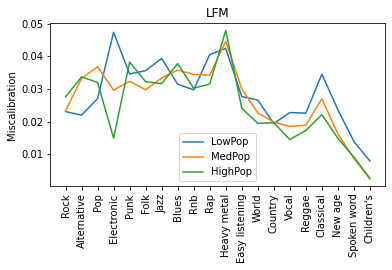

In [40]:
# durch reset_index nicht die selben index wie die gemergde tabelle, deshalb probleme
df_6 = df_test.copy(deep=True)#.sort_values('count',ignore_index=True, ascending=False).drop(range(20, 44)).reset_index(drop=True)
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_6[groups[i]] = MC_cat_d[algo_names[nmf]][i].to_frame()['mc']
df_6 = df_6.sort_values('count',ignore_index=True, ascending=False)
if dataset == 'anime':
    df_6 = df_6.drop(range(20, 36)).reset_index(drop=True)
    df_6 = df_6.drop(range(21, 28)).reset_index(drop=True)
    df_6 = df_6.drop(range(7, 8)).reset_index(drop=True)
df_6.plot.line(y=groups, x='category', figsize=(6, 3), legend=True)
labels = [label.capitalize() for label in list(df_6['category'])]

plt.title({'anime':'MAL', 'book':'BookCrossing', 'movie':'ML', 'music':'LFM', 'yahoo':'Yahoo! Movies'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
# if type == 'music':
plt.ylabel("Miscalibration")
plt.xlabel("")
plt.savefig('output/' + dataset + '_genre_mc_count_' + algo_names[nmf] + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Genre MAE sorted by count

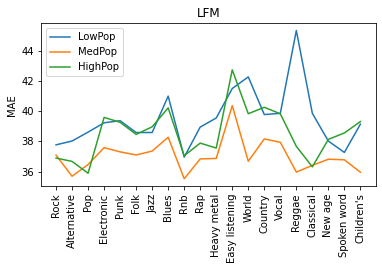

In [42]:
df_7 = df_test.copy(deep=True)
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_mae_item = maes[algo_names[nmf]]
    df_mae_item = df_mae_item.loc[df_mae_item['user'].isin([low_users, medium_users, high_users][i].index)].drop(['user'], axis=1)
    df_mae_item['item'] = df_mae_item['item'].astype(int)
    df_mae_item = df_mae_item.merge(df_item_cats,on='item', how='left')
    df_mae_item["cats"] = df_mae_item["cats"].str.split("|")
    df_7[groups[i]] = df_mae_item.explode("cats").reset_index(drop=True).drop(['item'], axis=1).groupby('cats')['mae'].mean().reset_index()['mae']

df_7 = df_7.sort_values('count',ignore_index=True, ascending=False)
if dataset == 'anime':
    df_7 = df_7.drop(range(20, 36)).reset_index(drop=True)
    df_7 = df_7.drop(range(21, 28)).reset_index(drop=True)
df_7.plot.line(y=groups, x='category', figsize=(6, 3))
labels = [label.capitalize() for label in list(df_7['category'])]

plt.title({'anime':'MAL', 'book':'BookCrossing', 'movie':'ML', 'music':'LFM', 'yahoo':'Yahoo! Movies'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
plt.ylabel("MAE")
plt.xlabel("")
plt.savefig('output/' + dataset + '_genre_mae_count_' + algo_names[nmf] + '.pdf', dpi=300, bbox_inches='tight')
plt.show()

## Genre popularity lift sorted by count

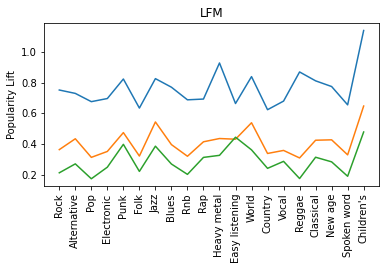

In [43]:
df_8 = df_test.copy(deep=True)
groups = ['LowPop', 'MedPop', 'HighPop']
for i in range(len(groups)):
    df_pl_items = pls_items[algo_names[nmf]]
    df_pl_items = df_pl_items.loc[df_pl_items['user'].isin([low_users, medium_users, high_users][i].index)].drop(['user'], axis=1)
    df_pl_items['item'] = df_pl_items['item'].astype(int)
    df_pl_items = df_pl_items.merge(df_item_cats,on='item', how='left')
    df_pl_items["cats"] = df_pl_items["cats"].str.split("|")
    df_8[groups[i]]  = df_pl_items.explode("cats").reset_index(drop=True).drop(['item'], axis=1).groupby('cats')['pl'].mean().reset_index()['pl']

df_8 = df_8.sort_values('count',ignore_index=True, ascending=False)
if dataset == 'anime':
    df_8 = df_8.drop(range(20, 36)).reset_index(drop=True)
    df_8 = df_8.drop(range(21, 28)).reset_index(drop=True)
    df_8 = df_8.drop(range(7, 8)).reset_index(drop=True)
df_8.plot.line(y=groups, x='category', figsize=(6, 3), legend=False)
labels = [label.capitalize() for label in list(df_8['category'])]

plt.title({'anime':'MAL', 'book':'BookCrossing', 'movie':'ML', 'music':'LFM', 'yahoo':'Yahoo! Movies'}[dataset])
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
# if type == 'music':
plt.ylabel("Popularity Lift")
plt.xlabel("")
plt.savefig('output/' + dataset + '_genre_pl_count_' + algo_names[nmf] + '.pdf', dpi=300, bbox_inches='tight')
plt.show()